# Diff-SCM

This tutorial illustrates how to load the 2D BRATS dataset.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer

# TODO: Add right import reference after deployed
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.1.dev2247
Numpy version: 1.20.0
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a201cb93d8fb49e6c7070fa22d86e6582c8adb2a
MONAI __file__: /remote/rds/users/s2086085/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.17.2
Pillow version: 8.1.1
Tensorboard version: 2.8.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.0
einops version: 0.4.1
transformers version: 4.19.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-de

## Setup data directory

In [24]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp6l7agkii


## Set deterministic training for reproducibility

In [3]:
set_determinism(42)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset).
Here, we will use the "Hand" and "HeadCT", where our conditioning variable `class` will specify the modality.

In [4]:
batch_size = 2
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image","label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0 ).float().squeeze()),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
nb_3D_images_to_mix = 2
train_loader_3D = DataLoader(train_ds, batch_size=nb_3D_images_to_mix, shuffle=True, num_workers=4)
print(f'Image shape {train_ds[0]["image"].shape}')

/remote/rds/users/s2086085/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


Image shape torch.Size([1, 64, 64, 64])


In [5]:
from typing import Dict
def get_batched_2d_axial_slices(data : Dict):
    images_3D = data['image']
    batched_2d_slices = torch.cat(images_3D.split(1, dim = -1), 0).squeeze(-1) # images_3D.view(images_3D.shape[0]*images_3D.shape[-1],*images_3D.shape[1:-1])
    slice_label = data['slice_label']
    #slice_label = (mask_label.reshape(mask_label.shape[0], -1, mask_label.shape[-1]).sum(1) > 0 ).float()
    slice_label = torch.cat(slice_label.split(1, dim = -1),0).squeeze()
    return batched_2d_slices, slice_label

### Visualisation of the training images

In [6]:
check_data = first(train_loader_3D)

Batch shape: torch.Size([128, 1, 64, 64])
Slices class: tensor([0., 0., 1., 0.])


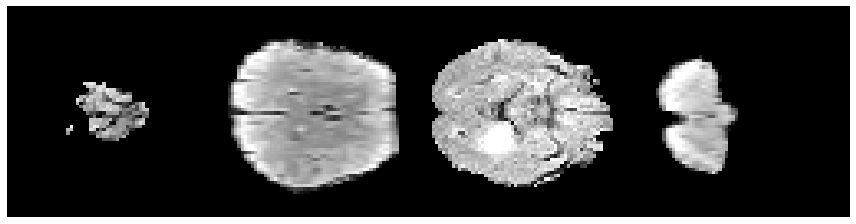

In [21]:
batched_2d_slices, slice_label = get_batched_2d_axial_slices(check_data)
idx = list(torch.randperm(batched_2d_slices.shape[0]))
slices = [0,30,45,63]
print(f"Batch shape: {batched_2d_slices.shape}")
print(f"Slices class: {slice_label[idx][slices].view(-1)}")
image_visualisation = torch.cat(batched_2d_slices[idx][slices].squeeze().split(1), dim=2).squeeze()
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [200]:
slice_label.shape

torch.Size([128])

## Check Distribution of Healthy / Unhealthy

In [22]:
batched_2d_slices, slice_label = get_batched_2d_axial_slices(check_data)
idx = list(torch.randperm(batched_2d_slices.shape[0]))
subset_2D = zip(batched_2d_slices.split(batch_size),slice_label.split(batch_size))#
a,b = next(subset_2D)
a.shape, b.shape

(torch.Size([2, 1, 64, 64]), torch.Size([2]))

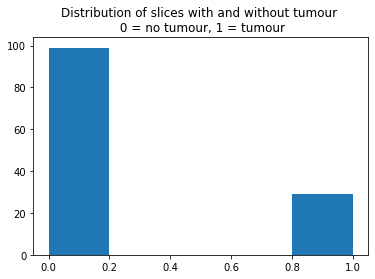

In [23]:
plt.hist(slice_label.view(-1).numpy(),bins = 5);
plt.title("Distribution of slices with and without tumour \n 0 = no tumour, 1 = tumour");